In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
box = pd.read_csv('boxing_matches.csv')

# Data preprocesing

We show all the NaN values in the initial DataSet.

We will remove useless columns that have almost every value to NaN. Also, we will impute values to columns that we need in order to remove the NaNs.

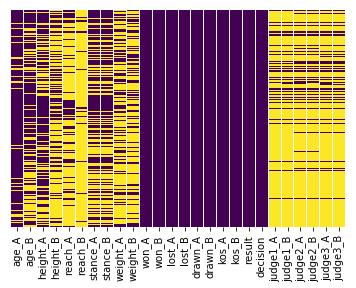

In [3]:
sns.heatmap(box.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [4]:
box.drop(['judge1_A', 'judge1_B', 'judge2_A', 'judge2_B', 'judge3_A', 'judge3_B', 'decision', 'reach_A', 'reach_B'], axis=1, inplace=True)

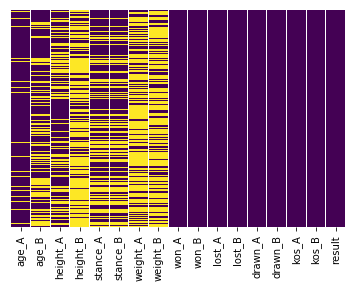

In [5]:
sns.heatmap(box.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Impute height and weight

For the NaNs in weight, I use the height due to the correlation between height and weight. The weight of the two boxers is almost the same, so we can use that too.

For the height, we use the weight in the same way but we have all the weights.

For the cases where we dont have any references, we use the mean. We precompute the mean because this way we dont compute it for every row(We went from 10 mins to 1 min).

In [6]:
weightMean = box['weight_A'].mean()

In [7]:
def impute_weight(cols):
    if pd.isna(cols[0]) and pd.isna(cols[1]): #weight
        if pd.isna(cols[2]) and pd.isna(cols[3]): #height
            return weightMean
        else:
            if not pd.isna(cols[2]):
                return cols[2]-20
            else:
                return cols[3]-20
    else:
        if pd.isna(cols[0]):
            return cols[1]
        else:
            return cols[0]

In [8]:
def impute_height(cols):
    weight = cols[1]
    if pd.isna(cols[0]):
        return weight+20
    else:
        return cols[0]

In [9]:
%%time
box['weight_A'] = box[['weight_A','weight_B', 'height_A', 'height_B']].apply(impute_weight,axis=1)
box['weight_B'] = box[['weight_A','weight_B', 'height_A', 'height_B']].apply(impute_weight,axis=1)

CPU times: user 56.5 s, sys: 46.3 ms, total: 56.6 s
Wall time: 56.3 s


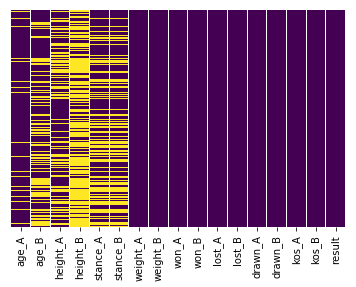

In [10]:
sns.heatmap(box.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
%%time
box['height_A'] = box[['height_A', 'weight_A']].apply(impute_height,axis=1)
box['height_B'] = box[['height_B', 'weight_B']].apply(impute_height,axis=1)

CPU times: user 44.4 s, sys: 79.7 ms, total: 44.5 s
Wall time: 44.2 s


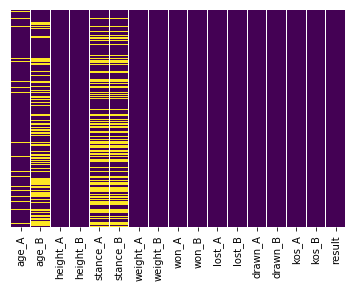

In [12]:
sns.heatmap(box.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Impute stance

Orthodox is the most common stance in boxing, so we use that.

In [13]:
def impute_stance(cols):
    if pd.isna(cols[0]):
        return 'orthodox'
    else: return cols[0]

In [14]:
%%time
box['stance_A'] = box[['stance_A']].apply(impute_stance,axis=1)
box['stance_B'] = box[['stance_B']].apply(impute_stance,axis=1)

CPU times: user 29.1 s, sys: 0 ns, total: 29.1 s
Wall time: 29.1 s


## Impute age

Same method.

In [15]:
ageMean = (box['age_A'].mean() + box['age_B'].mean())/2
print(ageMean)

25.499692995660926


In [16]:
def impute_age(cols):
    if pd.isna(cols[0]):
        return ageMean
    else: return cols[0]

In [17]:
%%time
box['age_A'] = box[['age_A']].apply(impute_age,axis=1)
box['age_B'] = box[['age_B']].apply(impute_age,axis=1)

CPU times: user 33.8 s, sys: 36 ms, total: 33.8 s
Wall time: 33.5 s


## Converting categorical variables

Using get_dummies() we convert the stance from a category to an indicator

In [18]:
stanceA = pd.get_dummies(box['stance_A'],drop_first=False)

In [19]:
stanceB = pd.get_dummies(box['stance_B'],drop_first=False)

In [20]:
box.drop(['stance_A', 'stance_B'], axis=1, inplace=True)

In [21]:
box = pd.concat([box,stanceA],axis=1)

In [22]:
box.drop(['southpaw'], axis=1, inplace=True)

In [23]:
box = box.rename(columns = {'orthodox':'orthodox_A'})

In [24]:
box = pd.concat([box,stanceB],axis=1)

In [25]:
box.drop(['southpaw'], axis=1, inplace=True)

In [26]:
box = box.rename(columns = {'orthodox':'orthodox_B'})

In [27]:
result = pd.get_dummies(box['result'],drop_first=True)

In [28]:
box = pd.concat([box, result], axis=1)

In [29]:
box.drop(['result', 'win_B'], axis=1, inplace=True)

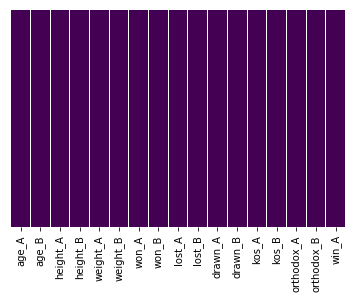

In [30]:
sns.heatmap(box.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [31]:
box.drop(['drawn_A', 'drawn_B'], axis=1, inplace=True)

In [32]:
box = box.dropna()

# Logistic Regression

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(box.drop('win_A',axis=1), 
                                                    box['win_A'], test_size=0.30)

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
predictions = logmodel.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.53      0.08      0.14     19733
          1       0.84      0.99      0.91     96472

avg / total       0.79      0.83      0.78    116205



In [40]:
print(confusion_matrix(y_test,predictions))

[[ 1529 18204]
 [ 1369 95103]]


# K Nearest Neighbours

## Choosing a K Value


## Predicting

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn.fit(X_train,y_train)

In [ ]:
pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,pred))

In [ ]:
print(classification_report(y_test,pred))

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,rfc_pred))

In [ ]:
print(classification_report(y_test,rfc_pred))